In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import pickle

In [4]:
from pegasos_experiment import generate_qsvm_data
from feature_maps import MediumFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit import Aer
from pegasos import pegasos
from sklearn.metrics import hinge_loss

In [13]:
# blue
color_0 = '#1f77b4'
color_0_light = '#8fbbd9'

# orange
color_1 = '#ff7f0e'
color_1_light = '#ffbf86'

colors = [color_0, color_1]
colors_light = [color_0_light,color_1_light]

# other constants
lower_percentile = 0.159
upper_percentile = 0.841

plt.rcParams.update({'font.size': 24,
                     'xtick.labelsize': 20,
                     'ytick.labelsize': 20,
                     'axes.titlesize': 28,
                     'axes.labelsize': 28,
                     'mathtext.fontset': 'stix',
                     'font.family': 'STIXGeneral'})

In [46]:
margin = 0.1
Ms = 2**np.arange(2,12)
N = 1000
C = 1000
tol = 1e-4

In [47]:
# Feature map for the experiment
feature_map = MediumFeatureMap(2,4)

# Kernel
adhoc_backend = QuantumInstance(Aer.get_backend('statevector_simulator'))
adhoc_kernel = QuantumKernel(feature_map=feature_map.get_reduced_params_circuit(), quantum_instance=adhoc_backend)

np.random.seed(41)
seeds = np.random.randint(0,10000,10)
dtypes = {'seed': int, 'C' : int, 'M' : int}
# Checking whether experiment has already been partially done and loading existing data
try:
    results = pd.read_csv(f'data/M_{margin}_data.csv',dtype=dtypes)
except:
    columns = ['seed','C','M']
    results = pd.DataFrame(columns=columns)
    results.to_csv(f'data/M_{margin}_data.csv',index=False)

for M in tqdm(Ms):
    if ((results['M'] == M) & (results['C'] == C)).any():
        print(f'Found M {M}')
        continue
    # Creating artificial data
    (X,y), (Xt,yt) = generate_qsvm_data(feature_map,0.1,M,0)
    K = adhoc_kernel.evaluate(X)
    for s in seeds:
        y_preds, _,_,_ = pegasos(K,y,N,C,seed=s,full_returns=True)
        losses = [hinge_loss(y,yp) for yp in y_preds]
        pickle.dump(losses,open(f'data/dumps/M_dependence_{s}_C_{C}_M_{M}.pkl','wb'))
        results.loc[results.shape[0]] = [s,C,M]
        results.to_csv(f'data/M_{margin}_data.csv',index=False)

  0%|          | 0/10 [00:00<?, ?it/s]

Found M 4
[[1000.          355.46108491  119.93209466  359.55929357]
 [ 320.22035322  -16.85359218 -114.3853442  -320.22035322]
 [ 213.48023548  -11.23572812  -76.25689613 -213.48023548]
 ...
 [   1.51534288    1.32962278   -1.37608868   -1.85495757]
 [   1.51382602    1.32829183   -1.37471122   -1.85310076]
 [   1.51231219    1.32696353   -1.37333651   -1.85124766]]
[[ -119.93209466  -216.45382734 -1000.          -348.70278306]
 [  -59.96604733  -108.22691367  -500.          -174.35139153]
 [  -39.97736489   -72.15127578  -333.33333333  -116.23426102]
 ...
 [    1.51534288     1.32962278    -1.37608868    -1.85495757]
 [    1.51382602     1.32829183    -1.37471122    -1.85310076]
 [    1.51231219     1.32696353    -1.37333651    -1.85124766]]
[[1000.          355.46108491  119.93209466  359.55929357]
 [ 500.          177.73054246   59.96604733  179.77964678]
 [ 293.35596845   46.33575252 -293.35596845    3.61883684]
 ...
 [   1.51534288    1.32962278   -1.37608868   -1.85495757]
 [   

 10%|█         | 1/10 [00:04<00:40,  4.45s/it]

Found M 8
[[-749.20879513  -73.57092541 -119.93209466 ... -348.70278306
  -216.45382734 -319.49997284]
 [-193.90881626  157.34634611  129.11725971 ...  146.93575317
   325.34179497  340.25001358]
 [-129.27254417  104.89756408   86.07817314 ...   97.95716878
   216.89452998  226.83334239]
 ...
 [  -1.54310808    1.45826665    1.66473054 ...   -1.17028532
     1.91289048    1.3141288 ]
 [  -1.54156343    1.45680693    1.66306415 ...   -1.16911387
     1.91097568    1.31281336]
 [  -1.54002186    1.45535012    1.66140108 ...   -1.16794475
     1.9090647     1.31150055]]
[[  30.37729286  567.0114246  1000.         ...  359.55929357
   355.46108491  378.16661408]
 [-365.02358634  235.30655683  374.10837298 ...   73.44094498
   101.64370855  156.70967797]
 [-243.34905756  156.87103789  249.40558198 ...   48.96062998
    67.76247237  104.47311865]
 ...
 [  -1.5602574     1.70125866    1.32060853 ...   -1.34421592
     1.81420195    1.2822709 ]
 [  -1.55869558    1.6995557     1.3192866  ...  

 20%|██        | 2/10 [00:08<00:35,  4.47s/it]

Found M 16
[[-519.90181865 -295.59287167 -128.35969524 ... -152.65386115
  -478.48265786 -999.08736548]
 [-259.95090933 -147.79643584  -64.17984762 ...  -76.32693057
  -239.24132893 -499.54368274]
 [-173.30060622  -98.53095722  -42.78656508 ...  -50.88462038
  -159.49421929 -333.02912183]
 ...
 [  -1.76368993    1.22841806    1.82366007 ...    3.1882226
    -1.94478272   -2.96404519]
 [  -1.76192448    1.22718841    1.82183458 ...    3.18503118
    -1.94283599   -2.96107817]
 [  -1.76016255    1.22596122    1.82001275 ...    3.18184615
    -1.94089316   -2.9581171 ]]
[[ 5.71171054e+02  4.09814519e+02  1.00000000e+03 ...  3.91215819e+02
   3.89168269e+02  1.37560660e+02]
 [ 2.85585527e+02  2.04907260e+02  5.00000000e+02 ...  1.95607910e+02
   1.94584135e+02  6.87803301e+01]
 [ 1.57673508e+01  3.64002462e+01  2.87479780e+02 ...  8.14927363e+01
  -3.40661235e+01 -2.87479780e+02]
 ...
 [-1.45197101e+00  1.84421425e+00  1.91450008e+00 ...  3.42360071e+00
  -7.76290698e-01 -2.13462286e+00]
 

 30%|███       | 3/10 [00:13<00:32,  4.63s/it]

Found M 32
[[-728.70392518 -822.86024469 -940.51159208 ...  -20.90062798
  -125.98009126 -753.11581226]
 [-118.65604426 -311.2030795  -404.73665925 ...  215.99572806
   199.12963877 -168.27438577]
 [ -79.10402951 -207.46871967 -269.8244395  ...  143.99715204
   132.75309251 -112.18292385]
 ...
 [  -1.76104418   -2.29842474   -3.70971969 ...    4.3938001
     1.52975085   -1.66880258]
 [  -1.75928137   -2.29612401   -3.70600626 ...    4.38940191
     1.52821957   -1.6671321 ]
 [  -1.75752209   -2.29382789   -3.70230025 ...    4.3850125
     1.52669135   -1.66546497]]
[[ -538.76070393  -817.81823183 -1000.         ...  -125.69746641
    -55.07489034  -601.14760122]
 [  -90.0339985   -340.02119792  -460.26367627 ...   218.90662415
    285.594375    -128.6428321 ]
 [  -60.02266567  -226.68079862  -306.84245085 ...   145.93774944
    190.39625      -85.76188807]
 ...
 [   -1.07859314    -1.67819452    -2.80525927 ...     4.50887368
      1.86698631    -1.07546672]
 [   -1.07751346    -1.676

 30%|███       | 3/10 [00:16<00:38,  5.55s/it]

[[-1000.          -502.75309177  -538.76070393 ...  -159.11409489
   -343.18215257  -861.84595115]
 [ -500.          -251.37654588  -269.38035196 ...   -79.55704744
   -171.59107628  -430.92297557]
 [ -239.40347205  -148.00062489  -155.56635134 ...   188.7449193
     77.33267166  -204.53241516]
 ...
 [   -1.14258055    -2.34386332    -3.55397403 ...     4.74301932
      2.00735213    -1.15269829]
 [   -1.14143683    -2.34151711    -3.5504165  ...     4.73827156
      2.00534277    -1.15154444]
 [   -1.14029539    -2.33917559    -3.54686608 ...     4.73353328
      2.00333742    -1.1503929 ]]


KeyboardInterrupt: 

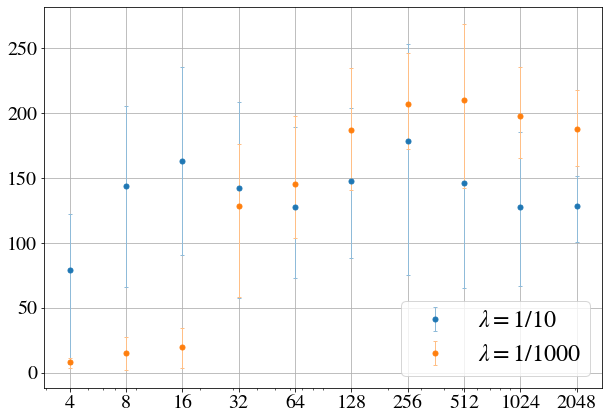

In [45]:
plt.figure(figsize=(10,7))
for k, C in enumerate([10,1000]):
    convergence_after = np.zeros((len(Ms),len(seeds)))
    for i, M in enumerate(Ms):
        for j, s in enumerate(seeds):
            filename = f'data/dumps/M_dependence_{s}_C_{C}_M_{M}.pkl'
            hinges = np.array(pickle.load(open(filename,'rb')))
            diff = np.abs(hinges[1:] - hinges[:-1])
            convergence_after[i,j] = np.where(diff < tol)[0][0]

    means = np.mean(convergence_after,axis=1)
    upper = np.quantile(convergence_after, upper_percentile, axis=1)
    lower = np.quantile(convergence_after,lower_percentile,axis=1)
    errors = np.array([means - lower, upper - means])
    
    plt.errorbar(Ms,means,yerr=errors,label=r'$\lambda = 1/{{%s}}$'%int(C),marker='.',ecolor=colors_light[k],elinewidth=1.,ls='',capsize=2,
            color=colors[k], ms=10)

plt.xscale('log')
plt.xticks(Ms,Ms)
plt.grid()
plt.legend()
plt.savefig('plots/pegasos_M_independent.png',dpi=300,bbox_inches='tight')

/var/folders/4n/frd9t6cx0ybc9csrrpzfk9mw0000gn/T/ipykernel_22583/2430216889.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


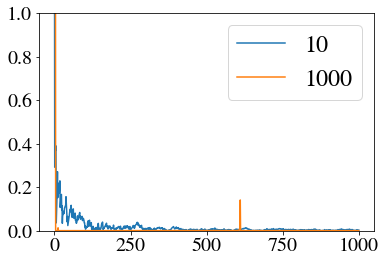

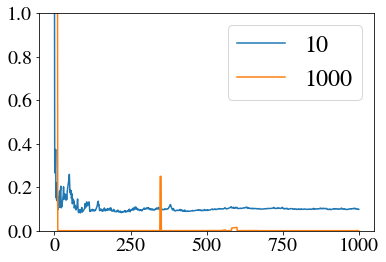

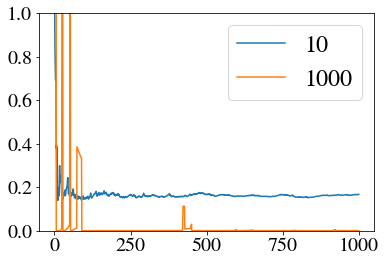

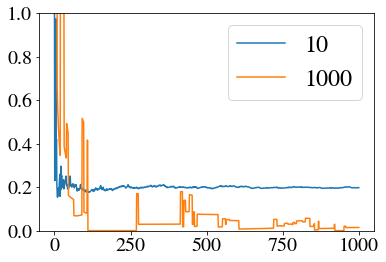

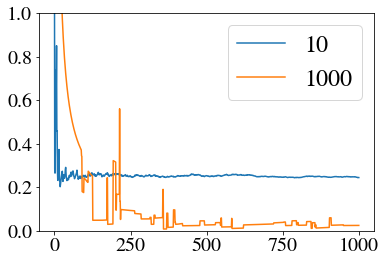

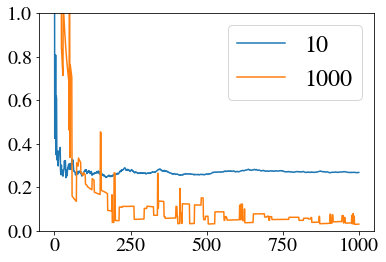

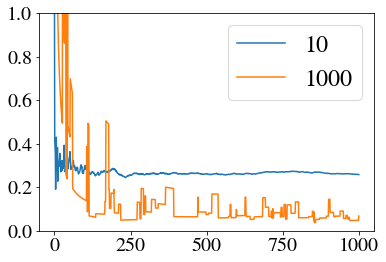

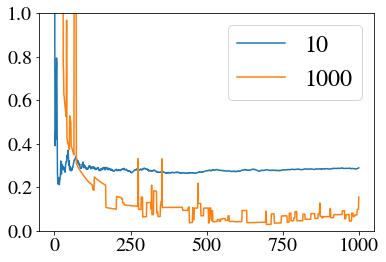

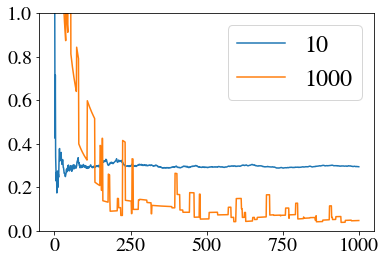

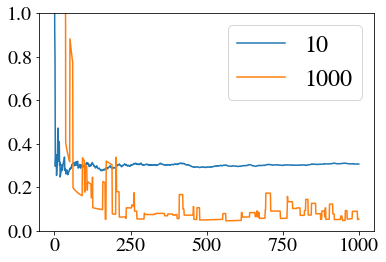

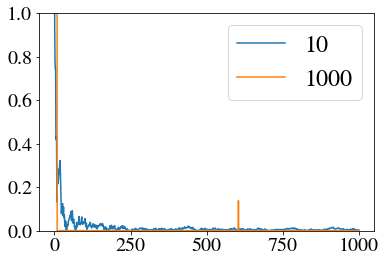

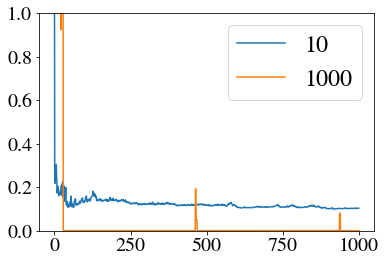

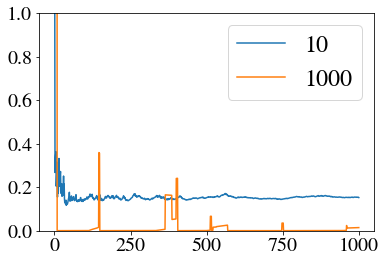

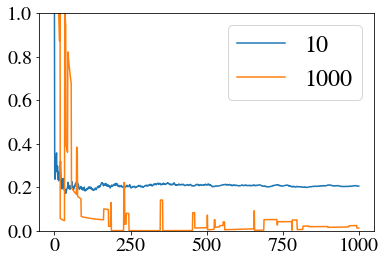

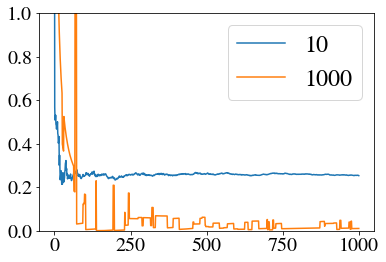

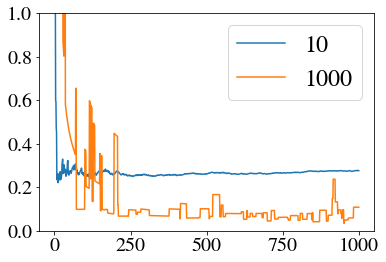

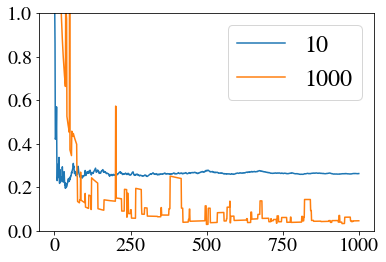

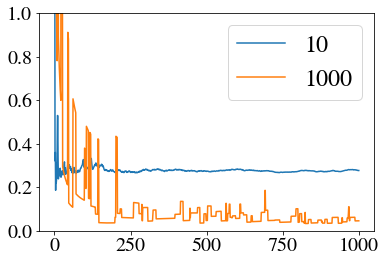

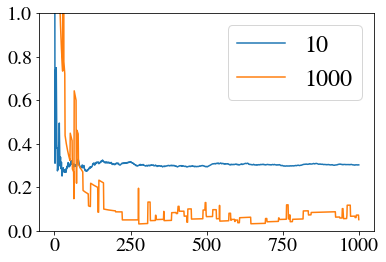

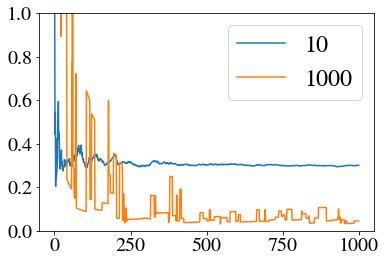

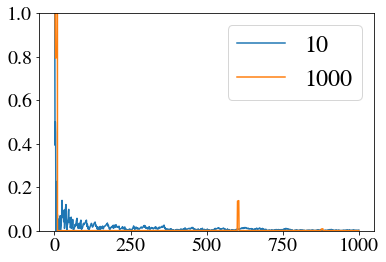

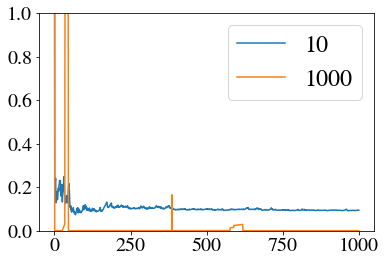

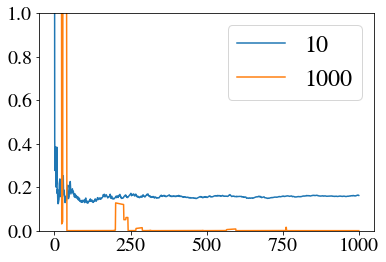

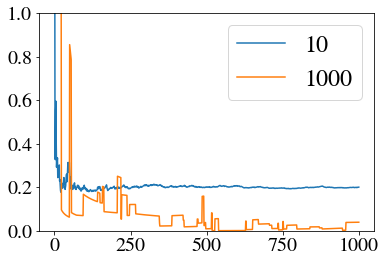

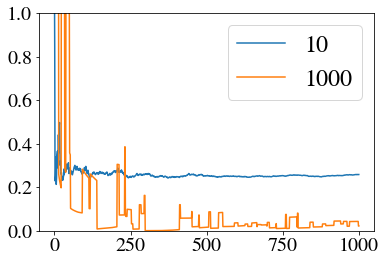

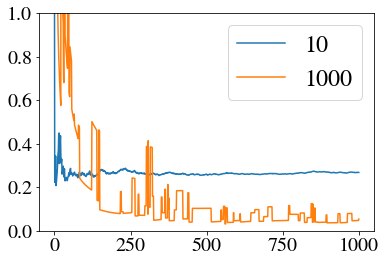

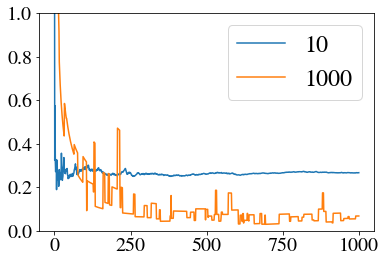

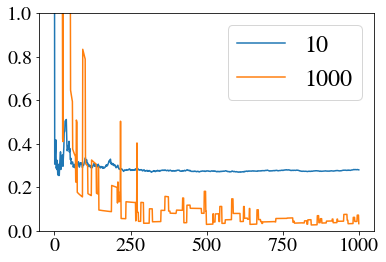

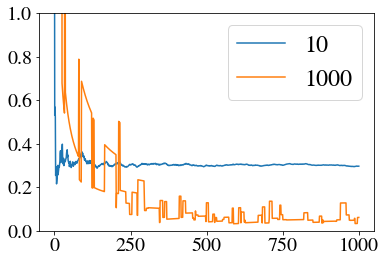

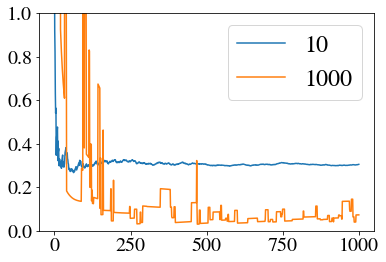

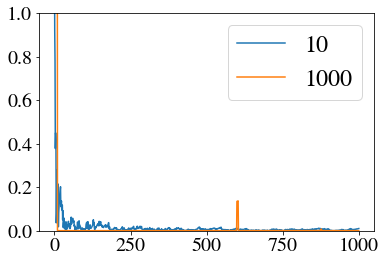

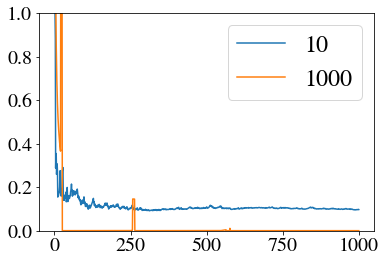

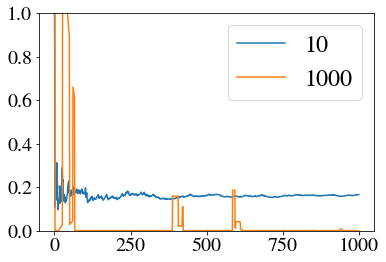

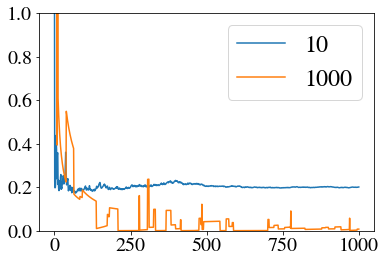

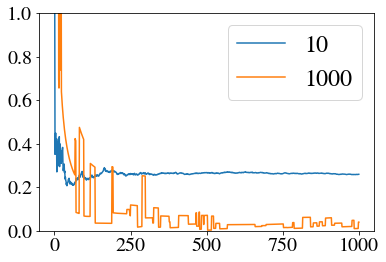

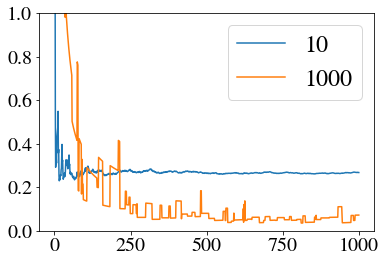

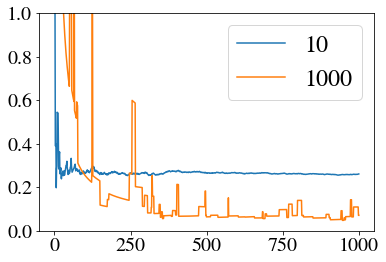

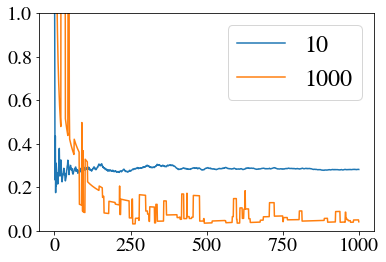

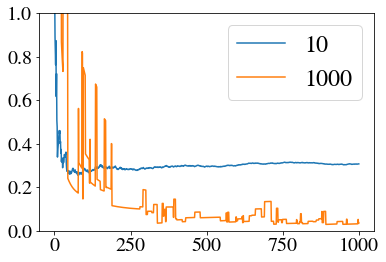

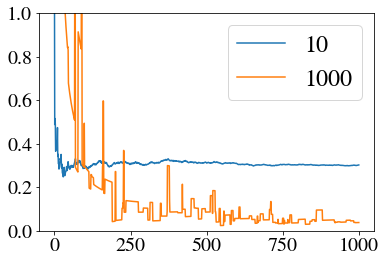

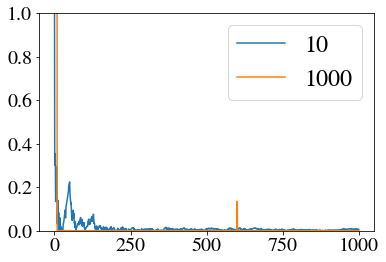

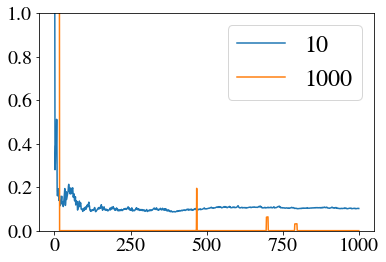

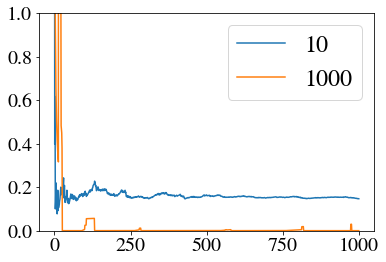

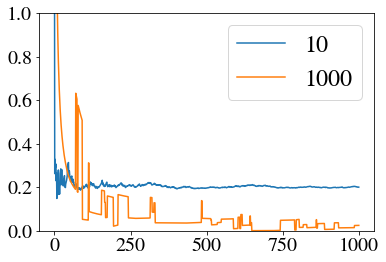

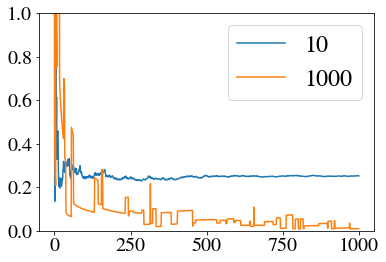

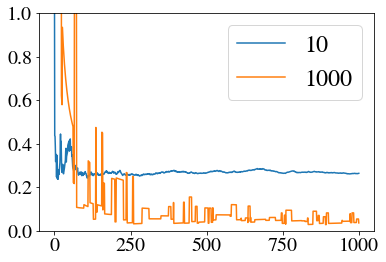

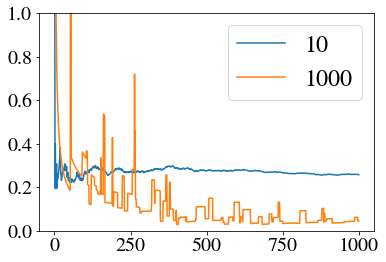

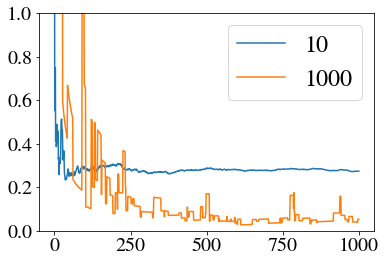

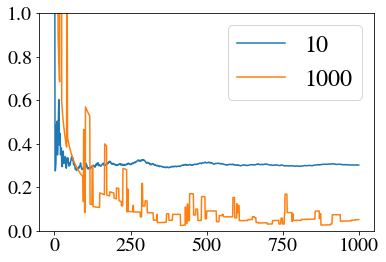

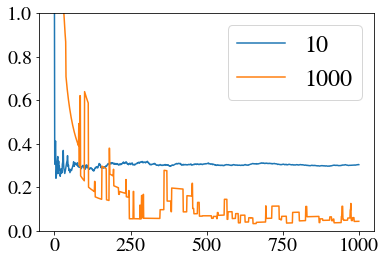

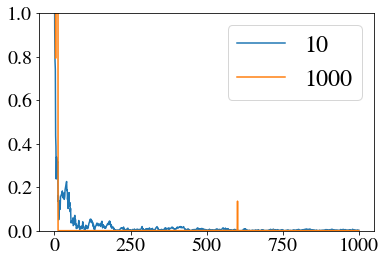

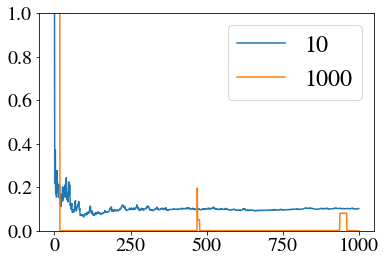

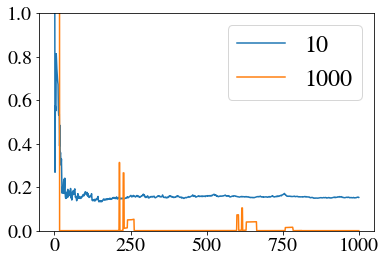

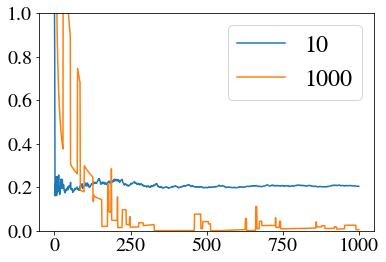

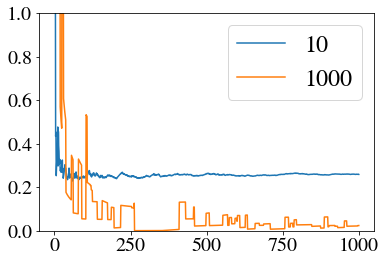

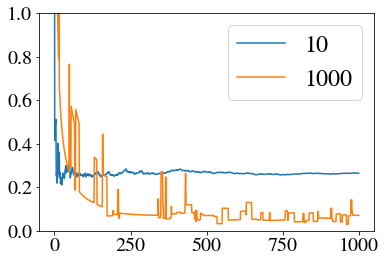

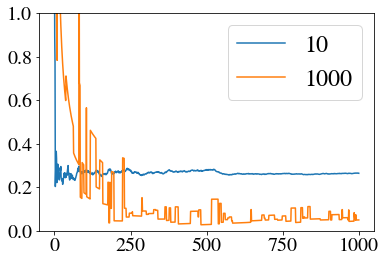

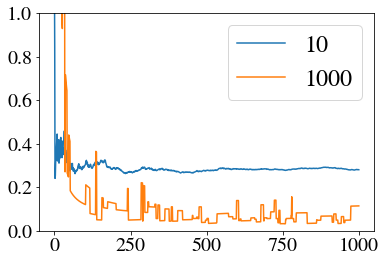

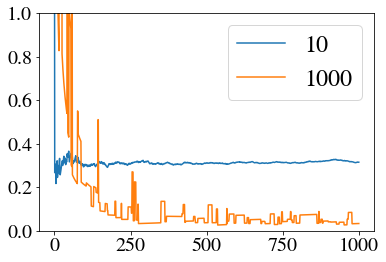

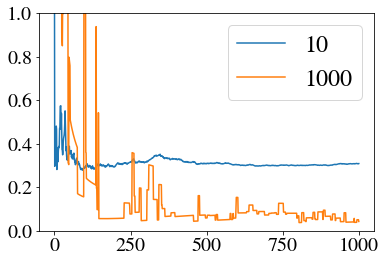

In [32]:
for j, s in enumerate(seeds):
    for i, M in enumerate(Ms):
        plt.figure()
        for k, C in enumerate([10,1000]):
            filename = f'data/dumps/M_dependence_{s}_C_{C}_M_{M}.pkl'
            hinges = np.array(pickle.load(open(filename,'rb')))
            plt.plot(hinges,label=C)
        plt.legend()
        plt.ylim(0,1)
    if j > 4:
        break


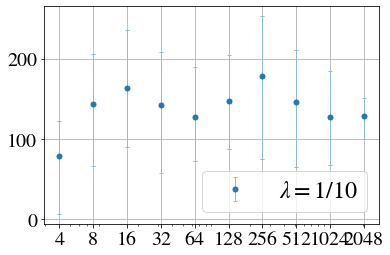